##Preparation
(Install, Import Library, Check Dataset)

In [1]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import tensorflow

import numpy as np # linear algebra
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import KFold
import random
import sys
import pandas
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import gc

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB2
from tensorflow.keras.applications import VGG19

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Check dataset
from google.colab import drive
drive.mount ('/content/drive')

base_dir = '/content/drive/MyDrive/New_Data_CoV2'
ct_scans = os.listdir(base_dir)
ct_scans

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Healthy', 'Covid', 'Others']

In [5]:
# Total dataset
total = 0

for i in ct_scans:
    dir = os.path.join(base_dir, i)
    num = len(os.listdir(dir))
    print(i+':', num, 'data')
    total = total + num

print('__________________________________')
print('\nTotal:', total, 'data')

Healthy: 757 data
Covid: 2188 data
Others: 1257 data
__________________________________

Total: 4202 data


## Pre-Processing

In [6]:
!pip install split-folders

In [7]:
# Split folder to divide the dataset into training, validation, and testing data
import splitfolders
splitfolders.ratio(base_dir, output="./train-test", seed=42, ratio=(.80, 0.1, 0.1))

Copying files: 4202 files [01:10, 59.85 files/s] 


In [8]:
# dataset directory
train_dir = 'train-test/train'
val_dir = 'train-test/val'
test_dir = 'train-test/test'

##Data Augmentation (Pre-processing)

In [9]:
# Hyperparameter Initiation
input_tensor  = Input(shape=(224,224,3))
learning_rate = 0.0001
epochs        = 60
image_size    = (224, 224)
batch_size    = 16

# Data augmentation on training data
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip = True,
                    fill_mode='nearest')

# Rescale on validation data
val_datagen = ImageDataGenerator(rescale=1./255)

#flow_from_directory() method takes a path of a directory and generates
# batches of augmented data.

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=image_size,
                    batch_size=batch_size,
                    shuffle=True,
                    class_mode='categorical',
                    #subset='training'
)

validation_generator = val_datagen.flow_from_directory(
                    val_dir,
                    target_size=image_size,
                    batch_size=batch_size,
                    shuffle=False,
                    class_mode='categorical',
                    #subset='validation'
)

Found 3360 images belonging to 3 classes.
Found 418 images belonging to 3 classes.


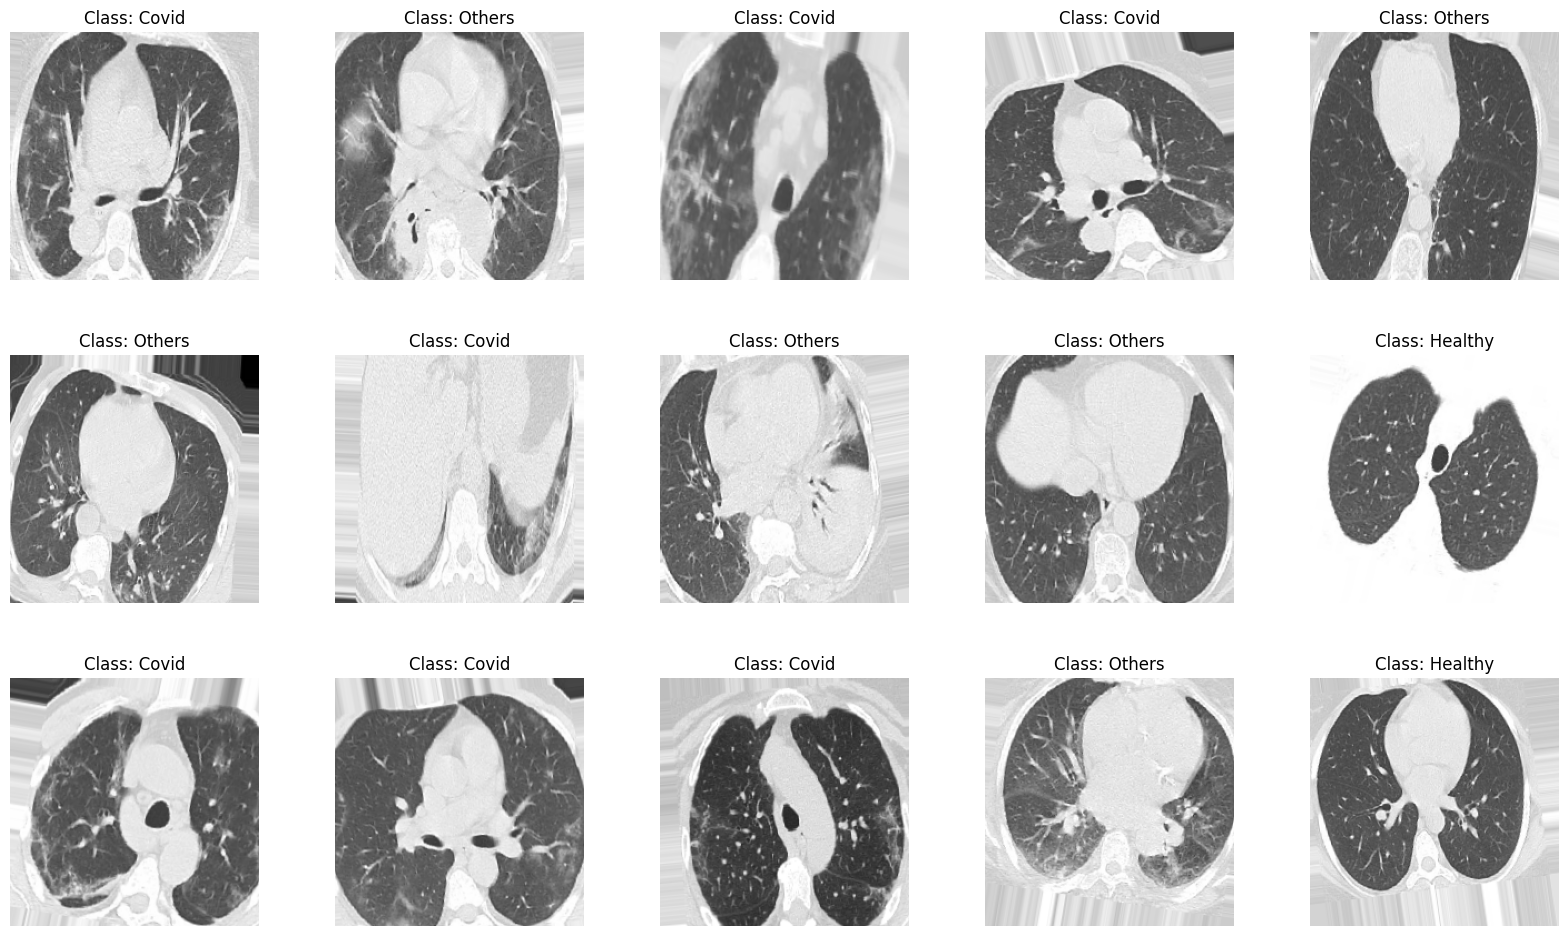

In [10]:
labels = [k for k in train_generator.class_indices]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

## Building Models with CNN (Convolutional Neural Network)

In [11]:
from keras.models import load_model

def getModel():
        base_model = VGG19(input_shape=(256, 256, 3),include_top=False, input_tensor=input_tensor)
        base_model = base_model.output
        model = GlobalAveragePooling2D()(base_model)
        model = Dense(256, activation='relu')(model)
        model = Dropout(0.2)(model)
        model = BatchNormalization()(model)
        model = Dense(3, activation='softmax')(model)
        model = Model(inputs=input_tensor, outputs=model)

        for layer in model.layers:
            layer.trainable = True

            model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])

        return model

model=getModel()

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

##Callbacks

In [13]:
# Save output model
model_file_path='./vgg19_model.hdf5'

# This callback will stop the training when there is no improvement in
# the val_loss for 20 consecutive epochs
early_stop = EarlyStopping(patience=20,
                          verbose=1,
                          mode='auto')

# Reduce learning rate when a metric has stopped improving.
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,
                                  verbose=1,factor=0.2, min_lr=0.000001)

# save the best model (best Validation Accuracy)
checkpoints = ModelCheckpoint(model_file_path,monitor='val_accuracy',
                                  mode='max',save_best_only=True)

##Model Training

In [14]:
model=getModel()

# fit model
steps_per_epoch=train_generator.n/batch_size
validation_steps=validation_generator.n/batch_size

history = model.fit(
              train_generator,
              steps_per_epoch=steps_per_epoch,  # how many batches will be executed in each epoch
              epochs=epochs,
              validation_data=validation_generator, # displays the accuracy of validation data testing
              validation_steps=validation_steps,  # how many batches will be executed in each epoch
              callbacks=[early_stop,learn_control,checkpoints],
              verbose=1)

Epoch 1/60
210/210 [==============================] - ETA: 0s - loss: 1.2815 - accuracy: 0.3735

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 102s 386ms/step - loss: 1.2815 - accuracy: 0.3735 - val_loss: 2.0423 - val_accuracy: 0.5215 - lr: 1.0000e-04
Epoch 2/60
210/210 [==============================] - 80s 378ms/step - loss: 1.2237 - accuracy: 0.4057 - val_loss: 1.5453 - val_accuracy: 0.3349 - lr: 1.0000e-04
Epoch 3/60
210/210 [==============================] - 77s 368ms/step - loss: 1.0519 - accuracy: 0.5190 - val_loss: 5.2077 - val_accuracy: 0.5215 - lr: 1.0000e-04
Epoch 4/60
210/210 [==============================] - 79s 377ms/step - loss: 1.0286 - accuracy: 0.5262 - val_loss: 1.2927 - val_accuracy: 0.5024 - lr: 1.0000e-04
Epoch 5/60
210/210 [==============================] - 78s 371ms/step - loss: 0.9820 - accuracy: 0.5473 - val_loss: 1.4324 - val_accuracy: 0.4306 - lr: 1.0000e-04
Epoch 6/60
210/210 [==============================] - 85s 404ms/step - loss: 0.9638 - accuracy: 0.5455 - val_loss: 0.8758 - val_accuracy: 0.6196 - lr: 1.0000e-04
Epoch 7/60
210/210 [==================

##Model Evaluation

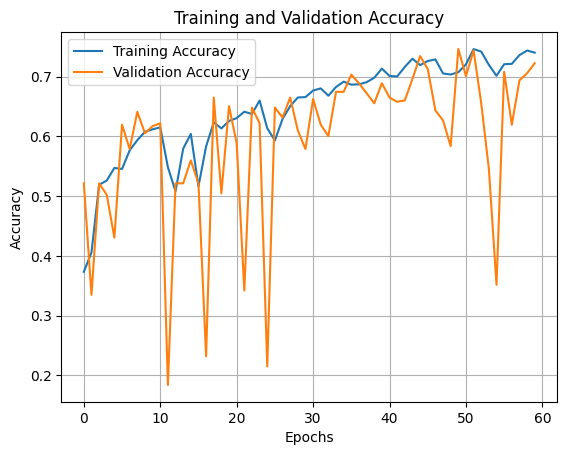

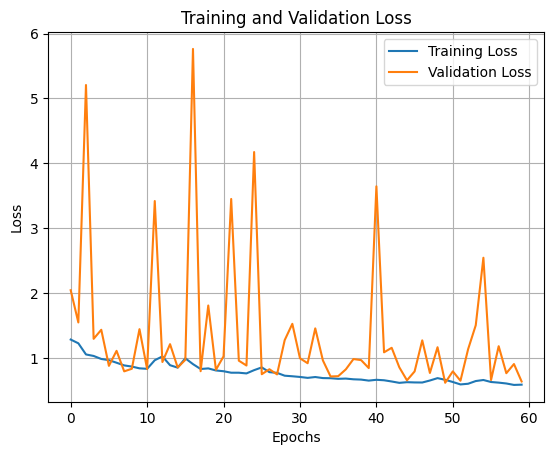

In [15]:
# Plot Model Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Model Loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
plt.plot(epochs, loss_train,  label='Training Loss')
plt.plot(epochs, loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Confusion Matrix and Classification Report

27/27 [==============================] - 3s 91ms/step - loss: 0.6151 - accuracy: 0.7464
Train Accuracy: 69.82%
Validation Accuracy: 74.64%
26/26 [==============================] - 3s 92ms/step


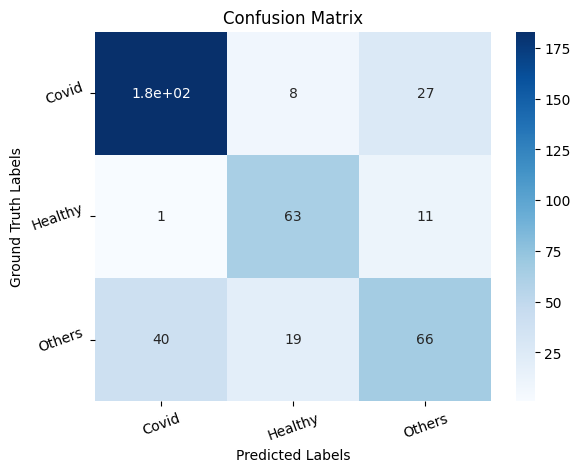

<Figure size 300x300 with 0 Axes>


              ---Classification Report---

              precision    recall  f1-score   support

       Covid     0.8170    0.8394    0.8281       218
     Healthy     0.7000    0.8400    0.7636        75
      Others     0.6346    0.5280    0.5764       125

    accuracy                         0.7464       418
   macro avg     0.7172    0.7358    0.7227       418
weighted avg     0.7414    0.7464    0.7412       418



In [16]:
#Load model
model.load_weights(model_file_path)
validation_generator.reset()

# Model evaluation
scores_train = model.evaluate(train_generator,verbose=1)
scores_validation = model.evaluate(validation_generator, verbose=1)
print("Train Accuracy: %.2f%%" % (scores_train[1]*100))
print("Validation Accuracy: %.2f%%" % (scores_validation[1]*100))

# Model Prediction
pred=model.predict(validation_generator, steps=validation_steps, verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

actual_class = validation_generator.classes
actual = [labels[k] for k in actual_class]
val_labels = [fn.split('/')[0] for fn in actual]

target_names=list(validation_generator.class_indices.keys())

# Confusion Matrix
cm=confusion_matrix(val_labels, predictions)

# Confusion Matrix Figure
fig = sns.heatmap(cm, annot=True, cmap = "Blues")
fig.set(title = 'Confusion Matrix', xlabel='Predicted Labels', ylabel='Ground Truth Labels')
fig.set_xticklabels(target_names,rotation=20)
fig.set_yticklabels(target_names,rotation=20)
plt.figure(figsize=(3,3))
plt.show(fig)

# Classification Report
cr=classification_report(val_labels, predictions, digits=4)
print("\n              ---Classification Report---\n")
print(cr)

##Testing Model

Found 423 images belonging to 3 classes.
26/26 [==============================] - 5s 184ms/step
[[189   7  23]
 [  1  54  22]
 [ 37  23  67]]


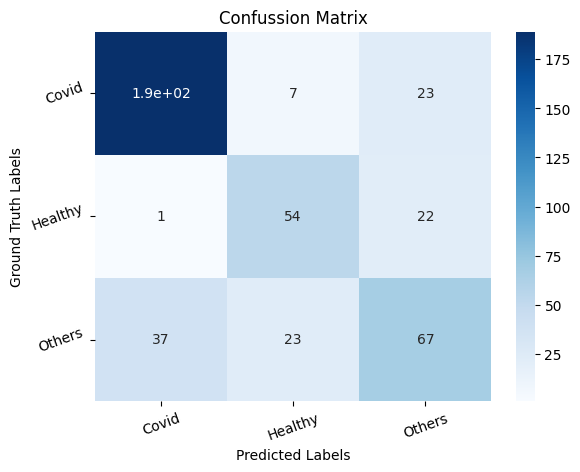

<Figure size 300x300 with 0 Axes>


              ---Classification Report---

              precision    recall  f1-score   support

       Covid     0.8326    0.8630    0.8475       219
     Healthy     0.6429    0.7013    0.6708        77
      Others     0.5982    0.5276    0.5607       127

    accuracy                         0.7329       423
   macro avg     0.6912    0.6973    0.6930       423
weighted avg     0.7277    0.7329    0.7292       423



In [17]:
# Rescale
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size=image_size,
                 batch_size=batch_size,
                 class_mode=None,
                 shuffle=False)
test_steps=test_generator.n/batch_size
test_generator.reset()

#Calling the saved model for making predictions
model_file='./vgg19_model.hdf5'
tl_img_aug_cnn = load_model(model_file)
pred=tl_img_aug_cnn.predict(test_generator,
                            verbose=1,
                            steps=test_steps)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results_test.csv",index=False)
target_names=list(validation_generator.class_indices.keys())
test_labels = [fn.split('/')[0] for fn in filenames]
cm=confusion_matrix(test_labels,predictions)
print(cm)


#Confussion Matrix Figure
fig = sns.heatmap(cm, annot=True, cmap = "Blues")
fig.set(title = 'Confussion Matrix', xlabel='Predicted Labels', ylabel='Ground Truth Labels')
fig.set_xticklabels(target_names,rotation=20)
fig.set_yticklabels(target_names,rotation=20)
plt.figure(figsize=(3,3))
plt.show(fig)

#Classification Report
cr=classification_report(test_labels, predictions, digits=4)
print("\n              ---Classification Report---\n")
print(cr)

In [18]:
!zip -r /content/train-test.zip /content/train-test

  adding: content/train-test/ (stored 0%)
  adding: content/train-test/val/ (stored 0%)
  adding: content/train-test/val/Healthy/ (stored 0%)
  adding: content/train-test/val/Healthy/Healthy (93).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (637).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (292).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (8).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (467).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (330).png (deflated 0%)
  adding: content/train-test/val/Healthy/Healthy (390).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (95).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (450).png (deflated 1%)
  adding: content/train-test/val/Healthy/Healthy (345).png (deflated 0%)
  adding: content/train-test/val/Healthy/Healthy (341).png (deflated 0%)
  adding: content/train-test/val/Healthy/Healthy (226).png 